# Starting with Statistical Analysis
##### In this notebook we will only use the statistical methods to find out the best statistical model that predicts the future market behavior.
In this note, we will start with traditional `AR`, `MA` and the combination of two `ARMA` model.
We are here to find out the parameters or lags for these models and then we will just put those parameters to the `ARIMA` model with an extra parameter which is responsible for integration.

#### Step 0: Import Necessary Packages and Setup Meta Information Flow

In [1]:
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.distributions import chi2

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Step 1: Import the augmented csv and process it further

Import the augmented csv file

In [3]:
df = pd.read_csv("../data/dal_final.csv")
df.head()

,Date,Close,Volume
0,2007-06-01,16.945204,2299400.0
1,2007-06-04,16.329803,5692700.0
2,2007-06-05,16.425152,4510000.0
3,2007-06-06,16.407814,2595300.0
4,2007-06-07,16.017771,3062100.0


Perform a quick EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4280 non-null   object 
 1   Close   4280 non-null   float64
 2   Volume  4280 non-null   float64
dtypes: float64(2), object(1)
memory usage: 100.4+ KB


As we see above, there is no null values and all other values are in 64 bit floating point format.

Create Index for the Dataframe

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
df.shape

(4280, 2)

Implement a dicky-fuller testing function for stationarity

In [7]:
def augmented_dicky_fuller_test(data):
    result = sm.tsa.stattools.adfuller(data)
    data = [{
        "ADF_STATISTIC": f"{result[0]:.4f}",
        "P-VALUE": f"{result[1]:.4g}",
        "LAG": result[2],
        "Observations": result[3],
        "1%": f"{result[4]['1%']:.4f}",
        "LEFT_OF_1_PCT": result[0] < result[4]['1%'],
        "5%": f"{result[4]['5%']:.4f}",
        "10%": f"{result[4]['10%']:.4f}"
    }]
    return tabulate(data, headers="keys", tablefmt="pretty")

In [8]:
# test the Closing Price aka market price
print(augmented_dicky_fuller_test(df['Close']))

+---------------+---------+-----+--------------+---------+---------------+---------+---------+
| ADF_STATISTIC | P-VALUE | LAG | Observations |   1%    | LEFT_OF_1_PCT |   5%    |   10%   |
+---------------+---------+-----+--------------+---------+---------------+---------+---------+
|    -1.4093    | 0.5778  | 11  |     4268     | -3.4319 |     False     | -2.8622 | -2.5671 |
+---------------+---------+-----+--------------+---------+---------------+---------+---------+


In [9]:
# test the price volume
print(augmented_dicky_fuller_test(df['Volume']))

+---------------+-----------+-----+--------------+---------+---------------+---------+---------+
| ADF_STATISTIC |  P-VALUE  | LAG | Observations |   1%    | LEFT_OF_1_PCT |   5%    |   10%   |
+---------------+-----------+-----+--------------+---------+---------------+---------+---------+
|    -4.9787    | 2.446e-05 | 25  |     4254     | -3.4319 |     True      | -2.8622 | -2.5671 |
+---------------+-----------+-----+--------------+---------+---------------+---------+---------+


As we can see, `Close` is non-stationary in nature and `Volume` is stationary. So, we don't need to go hard on `Volume` data. And let's not indulge ourselves in doing volumatric analysis.

Let us see the seasonal decomposition of the `Close` data.

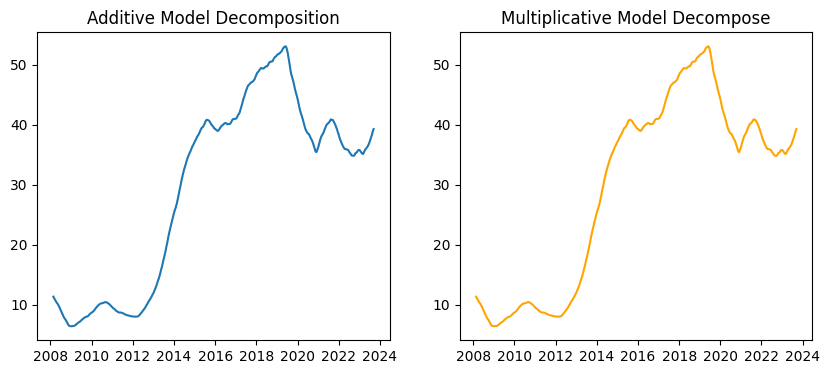

In [10]:
# Understanding Trends
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.trend)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.trend, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

As the above graph suggests, both the additive and multiplicative graph shows trendy nature of the closing prices. And the thing is, the prices are on up trend if we consider overall visuals.
We must now de-trend the data to make it feedable to the stats model.

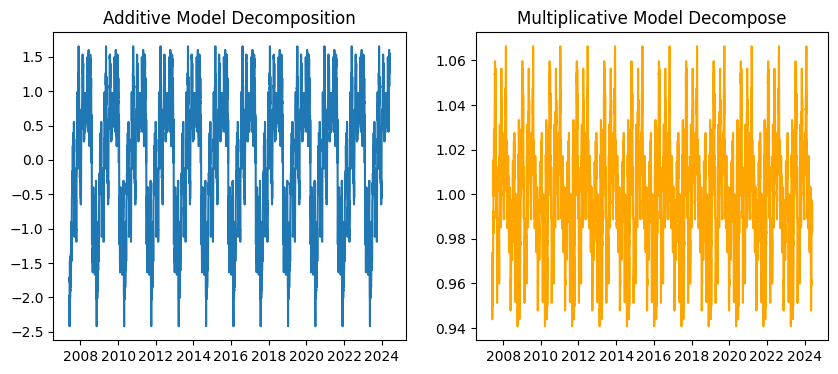

In [11]:
# Understanding Seasonality
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.seasonal)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.seasonal, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

As the graphs tell, both of them show significant seasonal appearences. We must eliminate the seasonality via differencing.

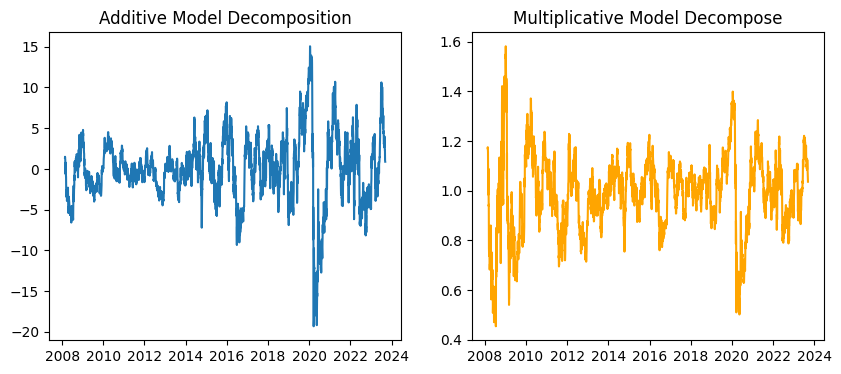

In [12]:
# Understanding Residuals
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.resid)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.resid, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

The graphs shows mean is 0 for additive model and 1 for multiplicative model. The standard deviation is not constant though. And again, correlation is visually not zero. So, the time series is not `white-noise`.

*** Strategy Development ***

Now my strategy for this kind of time-series would be to make sure to de-trend the time-series first of all. And I have to make it stationary as well. We have seen before that Adjusted Dicky-Fuller shows the time series is non-stationary.

task 1: To make it stationary, we need to just do general differencing.
task 2: To de-trend it, I have to apply seasonal differencing.


For task 1, we better use another financial ratio that is called ROI or return on investment or in simple words, returns. It just calculates the returns with reference to the previous price.

For task 2, we better fine tune the AR, MA model parameter p and q respectively, to address the seasonal differencing.

In [13]:
df['Returns'] = df['Close'].pct_change(1).mul(100)
df.dropna(inplace=True)
df.head()

,Close,Volume,Returns
Date,,,
2007-06-04,16.329803,5692700.0,-3.631708
2007-06-05,16.425152,4510000.0,0.583892
2007-06-06,16.407814,2595300.0,-0.105556
2007-06-07,16.017771,3062100.0,-2.377180
2007-06-08,16.321136,2124100.0,1.893932


Lets see the graph for Returns

<Axes: title={'center': 'Returns'}, xlabel='Date'>

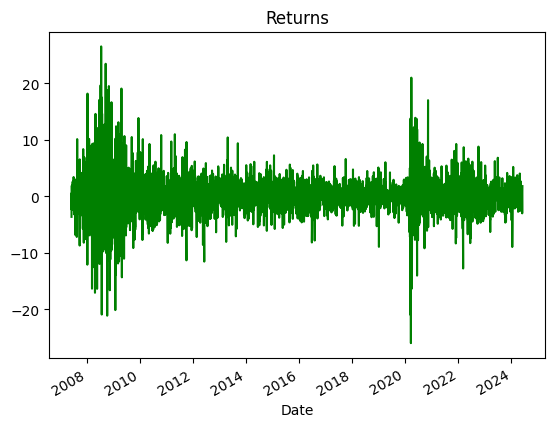

In [14]:
df['Returns'].plot(color="green", title="Returns")

As we can see above, the returns actually makes more sense as it is actually de-trending the time-series.

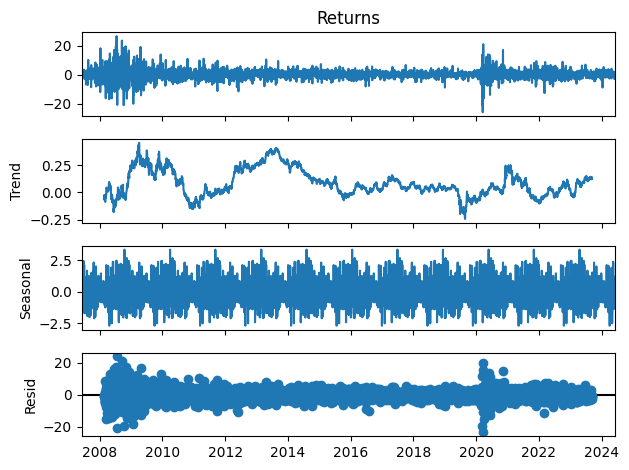

In [15]:
result_additive = sm.tsa.seasonal_decompose(df['Returns'], model="additive", period=365)
result_additive.plot()
plt.show()

As the above graph suggests, the time-series now cannot be identified as up trend or down trend. The line is now haphazard. And we cannot think of a multiplicative 

Now we can go ahead with this dataset. Let's save it in the folder.

In [16]:
df.to_csv('../data/dal_augmented_returns.csv')

#### Step 2: Start Developing the Model

Before getting to start building our model, we must have some tools in our hand already. We need something to understand if our model is either underfitting or overfitting, we also need something to compare across our models and we must need a tool that can help us with benchmarking our model.
But before all of that we need a tool to separate train and test dataset.

Split our time series into `train` and `test` part. We will use test for testing as the name suggests.

In [17]:
train_test_split_pct    = 0.8 # 80% train and 20% test
break_point             = int(0.8*df.shape[0])
train_df                = df[:break_point]
test_df                 = df[break_point:]
df_rows                 = df.shape[0]
train_df_rows           = train_df.shape[0]
test_df_rows            = test_df.shape[0]
equality_check          = "pass" if train_df_rows + test_df_rows == df_rows else "fail"
print(tabulate([{
    "df_rows": df_rows,
    "train_df_rows": train_df_rows,
    "test_df_rows": test_df_rows,
    "equality_check": equality_check 
}], headers="keys", tablefmt="pretty"))

+---------+---------------+--------------+----------------+
| df_rows | train_df_rows | test_df_rows | equality_check |
+---------+---------------+--------------+----------------+
|  4279   |     3423      |     856      |      pass      |
+---------+---------------+--------------+----------------+


We can use log-likelihood analysis for comparing models

In [27]:
def LLR(model1, model2, DF=1):
    restricted = model1.fit().llf # restricted 
    unrestricted = model2.fit().llf # unrestricted
    LR = 2*(restricted - unrestricted)
    return LR, chi2.sf(LR, DF).round(3)
def explain_llr(result):
    log_statistic, p_value = result
    return tabulate([{
        "log_statistic": log_statistic,
        "P-Value": p_value,
        "significant?": "yes" if p_value < 0.05 else "no"
    }], headers="keys")

Here, we are using one of the joint tests, LLR gives us both LR and P-Value,
if LR is greater and p-value is smaller that means unrestricted model is best.

In [34]:
from itertools import product

min = 999
AR_base = sm.tsa.arima.ARIMA(df['Returns'], order=(1, 0, 1))
for q in range(11):
    for p in range(11):
        print(f"p = {p} q = {q}")
        AR_high = sm.tsa.arima.ARIMA(df['Returns'], order=(p, 0, q))
        print(explain_llr(LLR(AR_high, AR_base, abs(p-q))))

p = 0 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
       -4.08476        nan  no
p = 1 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
      -0.100295          1  no
p = 2 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
       0.220613      0.896  no
p = 3 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
         4.5383      0.209  no
p = 4 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        5.38466       0.25  no
p = 5 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        24.3494          0  yes
p = 6 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        41.2942          0  yes
p = 7 q = 0
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        45.32

In [37]:
ARMA = sm.tsa.arima.ARIMA(df['Returns'], order=(9, 0, 10))

In [38]:
arma = ARMA.fit()

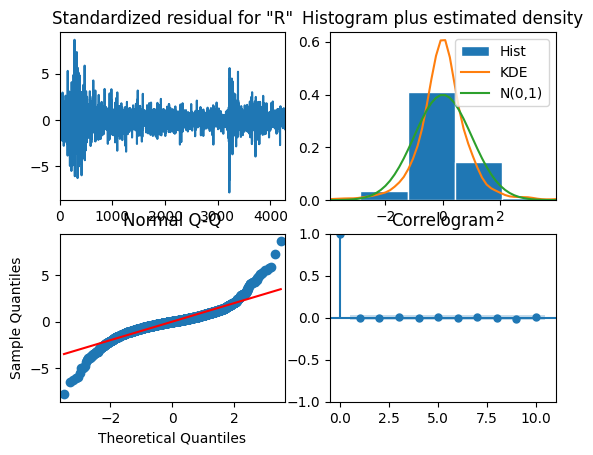

In [40]:
arma.plot_diagnostics()
plt.show()

In [41]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 4279
Model:                ARIMA(9, 0, 10)   Log Likelihood              -11080.049
Date:                Sat, 04 Oct 2025   AIC                          22202.098
Time:                        00:00:47   BIC                          22335.689
Sample:                             0   HQIC                         22249.291
                               - 4279                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0787      0.046      1.723      0.085      -0.011       0.168
ar.L1          0.7803      0.491      1.589      0.112      -0.182       1.743
ar.L2          0.0235      0.388      0.061      0.952      -0.736       0.783
ar.L3          0.6862      0.254      2.704      0.007       0.189       1.183
ar.L4         -1.1527      0.356     -3.240      0.001      -1.850      -0.455
ar.L5          0.5028      0.664      0.758      0.449      -0.798       1.803
ar.L6         -0.4004      0.203     -1.971      0.049      -0.799      -0.002
ar.L7          0.6049      0.135      4.466      0.000       0.339       0.870
ar.L8         -0.5551      0.406     -1.367      0.172      -1.351       0.241
ar.L9          0.3780      0.239      1.584      0.113      -0.090       0.846
ma.L1         -0.7504      0.491     -1.529      0.126      -1.712       0.211
ma.L2         -0.0388      0.376     -0.103      0.918      -0.775       0.697
ma.L3         -0.7383      0.256     -2.882      0.004      -1.240      -0.236
ma.L4          1.1665      0.385      3.026      0.002       0.411       1.922
ma.L5         -0.5424      0.672     -0.807      0.420      -1.860       0.776
ma.L6          0.4268      0.194      2.198      0.028       0.046       0.807
ma.L7         -0.5825      0.143     -4.086      0.000      -0.862      -0.303
ma.L8          0.5770      0.394      1.465      0.143      -0.195       1.349
ma.L9         -0.3978      0.235     -1.691      0.091      -0.859       0.063
ma.L10        -0.0049      0.023     -0.220      0.826      -0.049       0.039
sigma2        10.3956      0.105     99.107      0.000      10.190      10.601
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13058.96
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
forecast = arma.forecast(steps=1000)

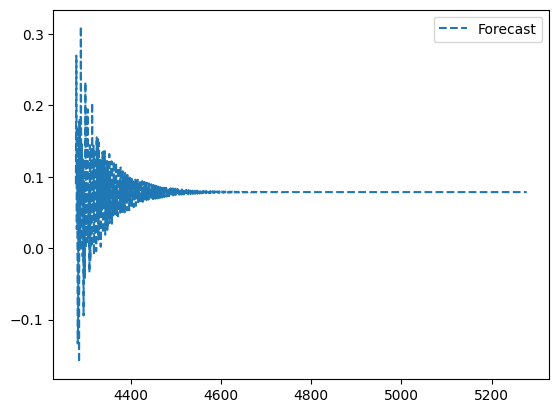

In [53]:
forecast.plot(label='Forecast', style='--')
plt.legend()
plt.show()